In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import root_mean_squared_log_error
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../cleaned_dataset_without_na.csv', delimiter='|')
data.head()

,title,area,number_of_rooms,floor,type_of_market,parking,elevator,year_of_creation,internet,type_of_building,basement,price_for_m2_in_PLN,balcony,garden,terrace,street,district,city,latitude,longtitude
0,"Apartament inwestycyjny, ostatnie piętro, k/Sk...",24.89,1.0,4-7,secondary,0,1,2022.0,1.0,Apartment,0.0,16749.98,0,0,0,śląska 12,przymorze,gdansk,54.406171,18.576846
1,Apartament inwestycyjny Śląska 12 z umową najmu!,25.72,1.0,0,secondary,0,1,2022.0,1.0,Apartment,0.0,18500.00,0,0,0,śląska 12,przymorze,gdansk,54.406171,18.576846
2,"Nowe mieszkanie, wykończone - Mariana Kołodzieja",34.38,2.0,1-3,secondary,1,1,2022.0,1.0,Apartment,0.0,15997.67,1,0,0,mariana kołodzieja,ujeścisko-łostowice,gdansk,54.334542,18.585750
3,"Wyjątkowe mieszkanie w centrum Gdyni, blisko l...",101.58,4.0,4-7,secondary,0,1,1997.0,1.0,Apartment,0.0,11468.79,0,0,0,janusza korczaka,redłowo,gdynia,54.494118,18.543134
4,Mieszkanie w świetnej lokalizacji Gdynia Dąbrowa,68.00,3.0,1-3,secondary,0,0,2000.0,1.0,Apartment,1.0,10279.41,1,0,0,oliwkowa,dąbrowa,gdynia,54.471180,18.470508


In [3]:
data = data.drop('title', axis=1)
threshold_low = 5000
threshold_high = 30000
data = data[data['price_for_m2_in_PLN'] >= threshold_low]
data = data[data['price_for_m2_in_PLN'] <= threshold_high]


In [4]:
data_numerical = data.drop(['city', 'district', 'type_of_market', 'type_of_building', 'floor', 'street'], axis=1)

In [5]:
data['city_district'] = data['city'] + '_' + data['district']

In [6]:
districts = data['city_district'].value_counts().to_dict()
data['city_district'] = data['city_district'].map(districts)

In [7]:
data = data.drop(['city', 'district'], axis=1)

In [8]:
A = data.drop(['price_for_m2_in_PLN', 'street'], axis=1)
b = data['price_for_m2_in_PLN']
X_train, X_test, y_train, y_test = train_test_split(A, b, test_size=0.2, random_state=0)

In [9]:
num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
preprocessor = ColumnTransformer([("cat", cat_pipeline, make_column_selector(dtype_include=object)),], remainder=num_pipeline)
preprocessor = preprocessor.fit(X_train, y_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

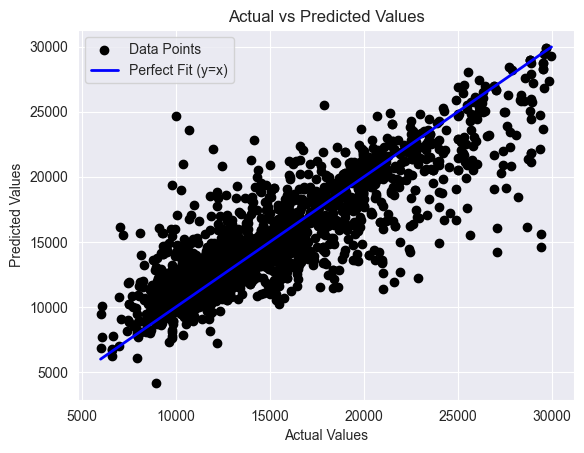

In [10]:
from xgboost import XGBRegressor
model_XGB = XGBRegressor()
model_XGB.fit(X_train_preprocessed, y_train)
y_pred_XGB = model_XGB.predict(X_test_preprocessed)

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred_XGB, color="black", label="Data Points")
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color="blue", linewidth=2, label="Perfect Fit (y=x)")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [11]:
rmse_XGB = root_mean_squared_error(y_test, y_pred_XGB)
rmse_XGB

np.float64(2393.709122856988)

In [12]:
from xgboost import XGBRegressor
model_XGB = XGBRegressor(eta=0.1, max_depth=7, n_estimators=300, objective='reg:squarederror')
model_XGB.fit(X_train_preprocessed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [13]:
rmse_XGB = root_mean_squared_error(y_test, y_pred_XGB)
rmse_XGB

np.float64(2393.709122856988)

In [14]:
r2_xgb = r2_score(y_test, y_pred_XGB)
r2_xgb

0.7541774002080043

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
mae_XGB = mean_absolute_error(y_test, y_pred_XGB)
mape_XGB = mean_absolute_percentage_error(y_test, y_pred_XGB)

In [16]:
metrics_df_XGB = pd.DataFrame({
    'metric': ['RMSE', 'R2', 'MAE', 'MAPE'],
    'value': [rmse_XGB, r2_xgb, mae_XGB, mape_XGB]
})
metrics_df_XGB.to_csv('../propertyApp/XGB_metrics.csv', sep='|', index=False, header=True)

In [17]:
import numpy as np

feature_importances = model_XGB.feature_importances_

feature_names = (
    preprocessor.named_transformers_['cat'][-1].get_feature_names_out(X_train.select_dtypes(include=object).columns)
    if 'cat' in preprocessor.named_transformers_
    else []
)
numeric_features = X_train.select_dtypes(exclude=object).columns
all_features = np.concatenate([numeric_features, feature_names])

feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)
print(feature_importance_df[feature_importance_df['Feature'] == 'latitude'])
print(feature_importance_df[feature_importance_df['Feature'] == 'longtitude'])

     Feature  Importance
10  latitude    0.020694
       Feature  Importance
11  longtitude    0.041294


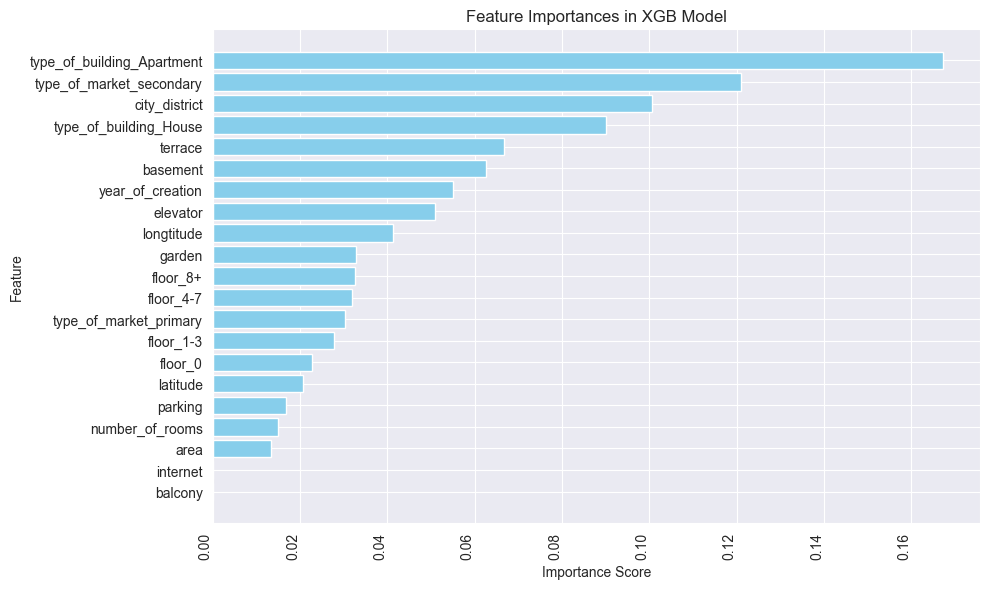

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances in XGB Model')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.savefig('../propertyApp/XGB_importance.png')
plt.show()


In [19]:
import joblib

joblib.dump(model_XGB, '../propertyApp/XGB.pkl')

['../propertyApp/XGB.pkl']